In [2]:

# conda create --name torch_env python=3.9
# conda activate torch_env

# conda install -c anaconda ipykernel
# python -m ipykernel install --user --name=torch_env

# conda install -c "nvidia/label/cuda-11.6.0" cuda-toolkit
# pip install torch==1.12.1+cu116 torchvision==0.13.1+cu116 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu116

# python -c "import torch; print(torch.version.cuda)"

# pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu116.html
# pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu116.html
# pip install torch-geometric
# pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.12.1+cu116.html
# pip install torch-cluster -f https://data.pyg.org/whl/torch-1.12.1+cu116.html

# pip install pyyaml tomli matplotlib sympy ipywidgets scikit-image


In [3]:
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.notebook import trange, tqdm
import yaml
%matplotlib notebook
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Current TODO:
1. ~~Add boundary sampling with particles~~
2. ~~Add offset boundary sampling~~
3. ~~Add akinci-like boundary treatment~~
4. ~~Add mirror pressure term to akinci boundary~~
5. ~~Add MLS pressure term to akinci boundary~~
6. ~~Add body forces to akinci boundary~~
7. Add drag forces to akinci boundary
6. ~~Add Pressure Boundaries approach (maybe)~~
6. ~~Add dense boundary sampling~~
6. ~~Add ghost particle based MLS pressure term in prep for delta sph~~
7. delta sph with fixed ghost particles
8. delta+ sph
9. Add RK4 somehow?!
10. delta sph with boundary integrals?!


# TODO:

1. ~~spherical emission~~
2. ~~adaptive timestepping~~
3. ~~divergence solver~~
4. ~~xsph viscosity~~
5. monaghan viscosity
6. ~~setup dambreak~~
7. setup dambreak with obstacle
8. setup flow past cylinder
9. add wcsph (müller)
10. add compressible sph
11. setup shockwave scenario for compressible sph
12. ~~density solver warm start~~
13. ~~particle shifting~~
14. shifting needs thresholding for free surfaces!! (delta+ sph paper shifting idea based on renormalization vector??)
15. ~~velocityBC~~
16. device integrals for sdf based renormalization matrix
17. ~~rewrite MLS interpolation for stability based on delta+ sph~~
18. ~~improve MLS performance~~
19. ~~improve overall performance~~

In [5]:
from src.simulationBase import SPHSimulation
from src.kernels import kernel, kernelGradient, spikyGrad, wendland, wendlandGrad, cohesionKernel, getKernelFunctions
from src.util import *
from src.module import Module
from src.parameter import Parameter

In [6]:
# import modules to build simulation with
from src.modules.density import densityModule
from src.modules.neighborSearch import neighborSearchModule
from src.modules.akinciTension import akinciTensionModule
from src.modules.sdfBoundary import sdfBoundaryModule, sdPolyDerAndIntegral
from src.modules.akinciBoundary import akinciBoundaryModule
from src.modules.solidBoundary import solidBoundaryModule
from src.modules.periodicBC import periodicBCModule
from src.modules.velocityBC import velocityBCModule
from src.modules.implicitShifting import implicitIterativeShiftModule
from src.modules.gravity import gravityModule
from src.modules.xsph import xsphModule
from src.modules.dfsph import dfsphModule
from src.modules.adaptiveDT import adaptiveTimeSteppingModule

In [7]:
# fig, axis = plt.subplots(2,2, figsize=(9 *  1.09, 9), squeeze = False)
# for axx in axis:
#     for ax in axx:
#         ax.set_xlim(sphSimulation.config['domain']['virtualMin'][0], sphSimulation.config['domain']['virtualMax'][0])
#         ax.set_ylim(sphSimulation.config['domain']['virtualMin'][1], sphSimulation.config['domain']['virtualMax'][1])
#         ax.axis('equal')
#         ax.axvline(sphSimulation.config['domain']['min'][0], ls= '--', c = 'black')
#         ax.axvline(sphSimulation.config['domain']['max'][0], ls= '--', c = 'black')
#         ax.axhline(sphSimulation.config['domain']['min'][1], ls= '--', c = 'black')
#         ax.axhline(sphSimulation.config['domain']['max'][1], ls= '--', c = 'black')

# positions = state['fluidPosition'].detach().cpu().numpy()
# # data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
# data = polyDer[:,0].detach().cpu().numpy()


# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = polyGrad[:,0].detach().cpu().numpy(), s = 4)
# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

In [8]:
from src.dfsph import dfsphSimulation

In [51]:
tomlConfig = """
[xsph]
fluidViscosity = 0.01
boundaryViscosity = 0.01

[pressure]
kappa = 1.5
gamma = 7.0

[timestep]
fixed = false
max = 0.005

[dfsph]
minDensitySolverIterations = 2
minDivergenceSolverIterations = 2
maxDensitySolverIterations = 256
maxDivergenceSolverIterations = 8
densityThreshold = 1e-3
divergenceThreshold = 1e-2
divergenceSolver = false
backgroundPressure = false
relaxedJacobiOmega = 0.5

[domain]
min = [-2, -2]
max = [2, 2]
adjustParticle = true
adjustDomain = true

[periodicBC]
periodicX = true
periodicY = true

[velocitySources]
[velocitySources.one]
min = [1,-2]
max = [2,2]
velocity = [0,1]

[emitter.fluidR]
fillDomain = false
min = [0.05,-0.25]
max = [0.5,0.25]
velocity = [ -1.0, 0.0]
adjust = false

[emitter.fluidL]
fillDomain = false
min = [-0.5,-0.25]
max = [-0.05,0.25]
velocity = [ 1.0, 0.0]
adjust = false

[emitter2.fluidBulk]
fillDomain = false
min = [-2,-2]
max = [-1.5, -1.5]
velocity = [ 0.0, 0.0]
adjust = true

[compute]
device='cpu'

[particle]
radius = 0.01

[gravity]
magnitude = 0

[simulation]
boundaryScheme = 'solid'
pressureTerm1 = 'PBSPH'
pressureTerm = 'ghostMLS'
pressureTerm2 = 'deltaMLS'
pressureTerm3 = 'MLSPressure'
verbose = false

[kernel]
targetNeighbors = 50

[akinciBoundary]
beta = 0.125
gamma = 0.7
""" 


In [52]:

class deltaSPHSimulation(SPHSimulation):    
    def __init__(self, config = tomli.loads('')):
        super().__init__(config)
        
        self.modules = []
        self.moduleParameters = []
        
        if self.verbose: print('Processing modules')
        self.neighborSearch = neighborSearchModule()
        self.sphDensity = densityModule()
        self.periodicBC = periodicBCModule()
#         self.DFSPH = dfsphModule()
        self.XSPH = xsphModule()
        self.velocityBC = velocityBCModule()
#         self.shiftModule = implicitIterativeShiftModule()
        self.gravityModule = gravityModule()
        self.adaptiveDT = adaptiveTimeSteppingModule()
        self.surfaceTension = akinciTensionModule()
        
        self.modules.append(self.neighborSearch)
        self.modules.append(self.sphDensity)
        self.modules.append(self.periodicBC)
        self.modules.append(self.velocityBC)
#         self.modules.append(self.DFSPH)
        self.modules.append(self.XSPH)
#         self.modules.append(self.shiftModule)
        self.modules.append(self.gravityModule)
        self.modules.append(self.adaptiveDT)
        self.modules.append(self.surfaceTension)    
        if self.config['simulation']['boundaryScheme'] == 'solid': 
            self.boundaryModule = solidBoundaryModule() 
            self.modules.append(self.boundaryModule)  
        if self.config['simulation']['boundaryScheme'] == 'SDF': 
            self.boundaryModule = sdfBoundaryModule() 
            self.modules.append(self.boundaryModule)  
        if self.config['simulation']['boundaryScheme'] == 'Akinci': 
            self.boundaryModule = akinciBoundaryModule() 
            self.modules.append(self.boundaryModule)  
        
        if self.verbose: print('Processing module parameters')
        for module in self.modules:    
            moduleParams =  module.getParameters()
            if moduleParams is not None:
                for param in moduleParams:
                    param.parseConfig(self.config)
                self.moduleParameters = self.moduleParameters + moduleParams
                
    def initializeSimulation(self):
        super().initializeSimulation()
        
        
    def timestep(self):
        step = ' 1 - Enforcing periodic boundary conditions'
        if self.verbose: print(step)
        with record_function(step):
            self.periodicBC.enforcePeriodicBC(self.simulationState, self)
            
        step = ' 2 - Fluid neighborhood search'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['fluidNeighbors'], self.simulationState['fluidDistances'], self.simulationState['fluidRadialDistances'] = self.neighborSearch.search(self.simulationState, self)
            
        step = ' 3 - Boundary neighborhood search'
        if self.verbose: print(step)
        with record_function(step):
            self.boundaryModule.boundaryFilterNeighborhoods(self.simulationState, self)
            self.boundaryModule.boundaryNeighborhoodSearch(self.simulationState, self)

#         step = ' 4 - Fluid - Fluid density evaluation'
#         if self.verbose: print(step)
#         with record_function(step):
#             self.simulationState['fluidDensity'] = self.sphDensity.evaluate(self.simulationState, self)    
#             self.periodicBC.syncQuantity(self.simulationState['fluidDensity'], self.simulationState, self)
        
#         step = ' 5 - Fluid - Boundary density evaluation'
#         if self.verbose: print(step)
#         with record_function(step):
#             self.simulationState['fluidDensity'] += self.boundaryModule.evalBoundaryDensity(self.simulationState, self)        
#             self.periodicBC.syncQuantity(self.simulationState['fluidDensity'], self.simulationState, self)
            
        step = ' 6 - Initializing acceleration'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['fluidAcceleration'][:] = 0. 
            
        step = ' 7 - External force evaluation'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['fluidAcceleration'] += self.gravityModule.evaluate(self.simulationState, self)
            self.periodicBC.syncQuantity(self.simulationState['fluidAcceleration'], self.simulationState, self)
        
        step = ' 9 - Surface tension force evaluation'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['fluidNormals'] = self.surfaceTension.computeNormals(self.simulationState, self)
            self.periodicBC.syncQuantity(self.simulationState['fluidNormals'], self.simulationState, self)
            self.simulationState['fluidCohesionForce'] = self.surfaceTension.cohesionForce(self.simulationState, self)
            self.simulationState['fluidCurvatureForce'] = self.surfaceTension.curvatureForce(self.simulationState, self)
            self.simulationState['fluidAcceleration'] += self.simulationState['fluidCurvatureForce']
            self.simulationState['fluidAcceleration'] += self.simulationState['fluidCohesionForce']
            self.periodicBC.syncQuantity(self.simulationState['fluidAcceleration'], self.simulationState, self)
            
        
        step = '11 - Velocity update step'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['fluidVelocity'] += self.simulationState['dt'] * self.simulationState['fluidAcceleration']
            self.periodicBC.syncQuantity(self.simulationState['fluidVelocity'], self.simulationState, self)
        
        step = '12 - XSPH diffusion evaluation'
        if self.verbose: print(step)
        with record_function(step):
            xsphFluidCorrection = self.XSPH.fluidTerm(self.simulationState, self)
            self.periodicBC.syncQuantity(xsphFluidCorrection, self.simulationState, self)
            self.simulationState['fluidVelocity'] += xsphFluidCorrection
        
#         step = ' 1 - Boundary friction evaluation'
#         if self.verbose: print(step)
#         with record_function(step):
#         self.boundaryModule.evalBoundaryFriction(self.simulationState, self)
#         xsphBoundaryCorrection = self.XSPH.boundaryTerm(self.simulationState, self)
#         self.periodicBC.syncQuantity(xsphBoundaryCorrection, self.simulationState, self)
#         self.simulationState['fluidVelocity'] += xsphBoundaryCorrection
        
        step = '13 - Velocity source contribution'
        if self.verbose: print(step)
        with record_function(step):
            self.velocityBC.enforce(self.simulationState, self)
            self.periodicBC.syncQuantity(self.simulationState['fluidVelocity'], self.simulationState, self)
        
        step = '14 - Position update step'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['fluidPosition'] += self.simulationState['fluidVelocity'] * self.simulationState['dt']
            
#         step = ' 1 - Shifting positions'
#         if self.verbose: print(step)
#         with record_function(step):
#         self.shiftModule.applyShifting(sphSimulation.simulationState, sphSimulation)
#         self.periodicBC.syncQuantity(self.simulationState['fluidUpdate'], self.simulationState, self)
#         self.simulationState['fluidPosition'] += self.simulationState['fluidUpdate']
        
        step = '15 - Bookkeeping'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['time'] += self.simulationState['dt']
            self.simulationState['timestep'] += 1

            self.simulationState['dt'] = self.adaptiveDT.updateTimestep(self.simulationState, self)

In [53]:

parsedConfig = tomli.loads(tomlConfig)
sphSimulation = deltaSPHSimulation(parsedConfig)

In [54]:
sphSimulation.initializeSimulation()
# for i in range(11):
# sphSimulation.timestep()

In [55]:
debugPrint(sphSimulation.simulationState['fluidPosition'].shape)

sphSimulation.simulationState['fluidPosition'].shape [Size] = torch.Size([1508, 2])


In [56]:
sphSimulation.timestep()

<IPython.core.display.Javascript object>


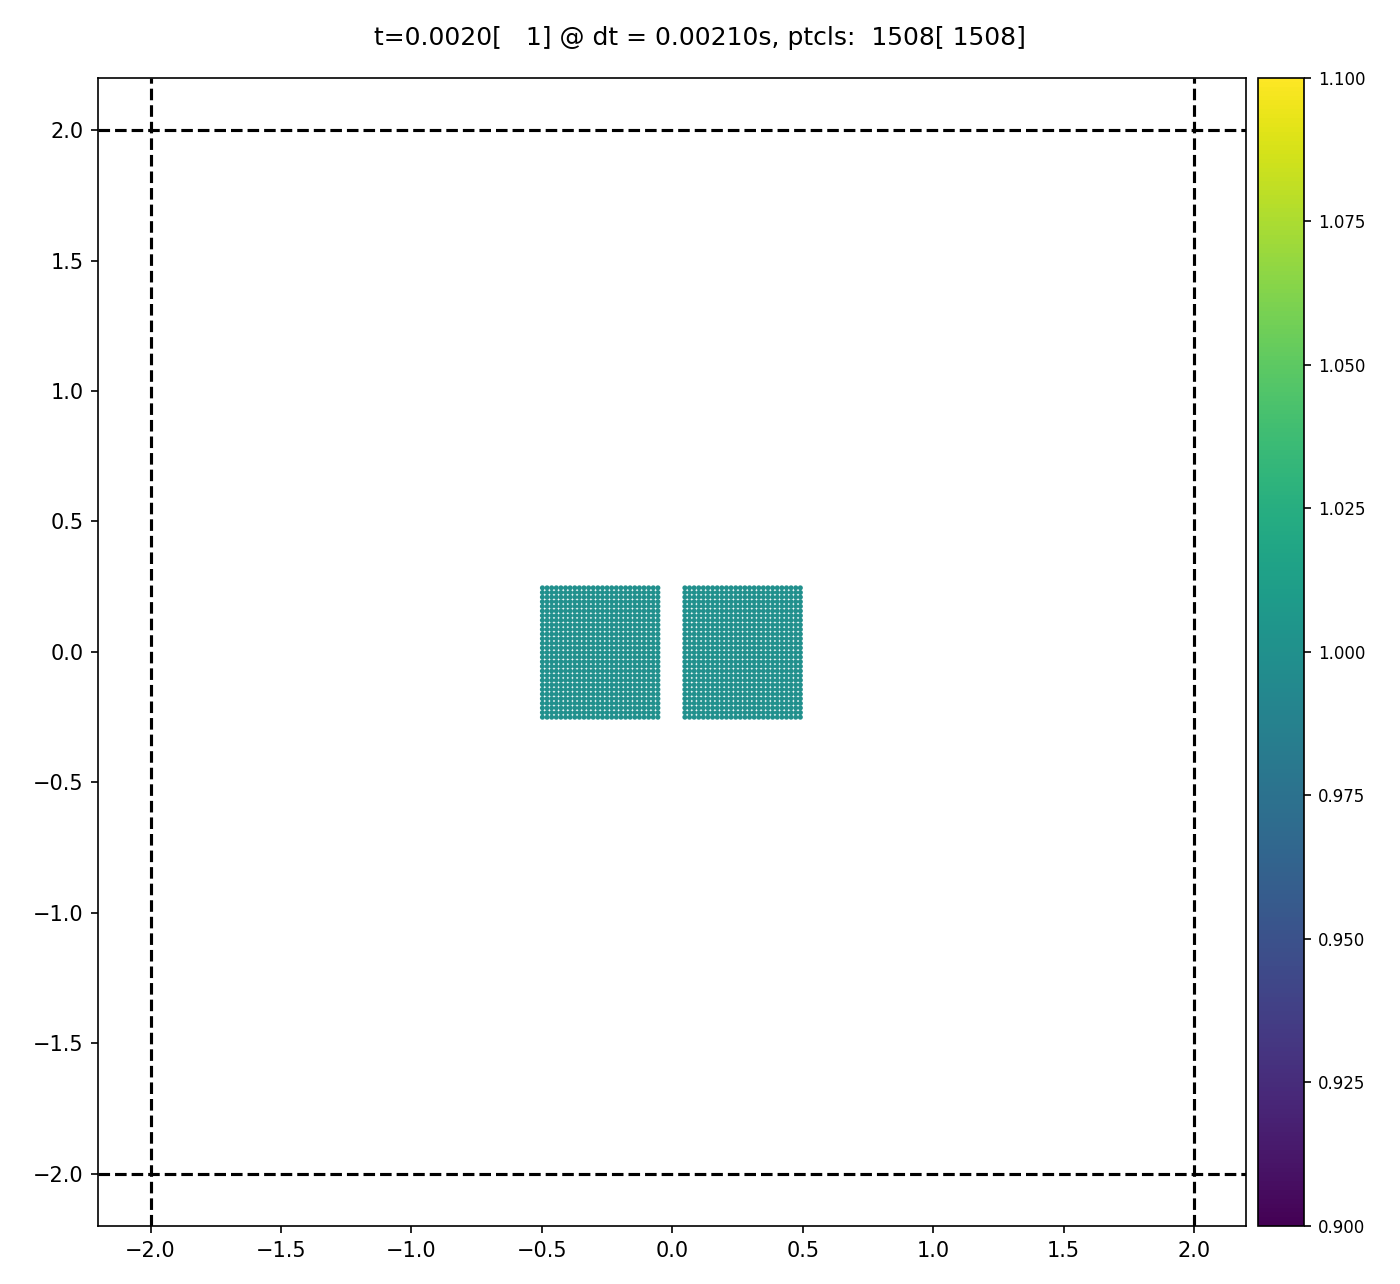

In [57]:

# parsedConfig = tomli.loads(tomlConfig)
# sphSimulation = torchSPH(parsedConfig)
# sphSimulation.initializeSimulation()
# sphSimulation.timestep()

fig, axis = sphSimulation.createPlot(plotScale = 2, plotSolids = False, plotDomain = True)

state = sphSimulation.simulationState


positions = state['fluidPosition'].detach().cpu().numpy()
# data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
# data2 = state['akinciBoundary']['boundaryDensity'].detach().cpu().numpy()
data = state['fluidDensity'].detach().cpu().numpy()
# data = state['fluidPressure'].detach().cpu().numpy()
# data = state['residual'].detach().cpu().numpy()
# data = state['fluidDensity'].detach().cpu().numpy()

# positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
# data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy()

# positions = np.vstack((positions, positions2))
# data = np.hstack((data, data2))

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

# quiverData = state['fluidUpdate'].detach().cpu().numpy()
# qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
#                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

# quiverData = state['lambdaGrad'].detach().cpu().numpy()
# qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
#                       scale_units='xy', scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)


fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
if 'densityErrors' in state and not 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
if 'divergenceErrors' in state and not 'densityErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
if 'densityErrors' in state and 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

fig.tight_layout()



In [58]:
sphSimulation.initializeSimulation()
simulationState = sphSimulation.simulationState
simulation = sphSimulation
support = simulation.config['particle']['support']
simulationState['fluidDensity'] = simulationState['fluidDensity'].type(torch.float32) * sphSimulation.config['fluid']['restDensity']

In [59]:
debugPrint(simulation.config['particle']['support'] * simulation.config['particle']['packing'])

simulation.config['particle']['support'] * simulation.config['particle']['packing'] [float64] = 0.017699115044247787


In [60]:
dx = simulation.config['particle']['support'] * simulation.config['particle']['packing']
c0 = 10.0 * np.sqrt(2.0*9.81*0.3)
h0 = simulation.config['particle']['support']
dt = 0.25 * h0 / (1.1 * c0)
debugPrint(c0)
debugPrint(dt)

c0 [float64] = 24.261079942986875
dt [float64] = 0.0006611403815069037


In [161]:

class deltaSPHModule(Module):
    def getParameters(self):
        return [
            Parameter('deltaSPH', 'alpha', 'float', 0.1, required = False, export = True, hint = ''),
            Parameter('deltaSPH', 'delta', 'float', 0.1, required = False, export = True, hint = ''),
            Parameter('deltaSPH', 'c0', 'float', 0.1, required = False, export = True, hint = '')
        ]
        
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
    
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']    
        self.backgroundPressure = simulationConfig['fluid']['backgroundPressure']
        self.restDensity = simulationConfig['fluid']['restDensity']
        
        self.boundaryScheme = simulationConfig['simulation']['boundaryScheme']
        self.boundaryCounter = len(simulationConfig['solidBC']) if 'solidBC' in simulationConfig else 0

        self.pressureScheme = simulationConfig['simulation']['pressureTerm'] 
        self.computeBodyForces = simulationConfig['simulation']['bodyForces'] 
        
        self.dtype = simulationConfig['compute']['precision']
        self.device = simulationConfig['compute']['device'] 
        
#         self.alpha = simulationConfig['deltaSPH']['alpha']
#         self.delta = simulationConfig['deltaSPH']['delta']  
        self.alpha = 0.1
        self.delta = 0.1
#         self.threshold = 1e-12
        self.c0 = 24.261079942986875
        self.eps = self.support **2 * 0.1
        
    def computeNormalizationMatrices(self, simulationState, simulation):
        neighbors = simulationState['fluidNeighbors']
        i = neighbors[0]
        j = neighbors[1]
        r = simulationState['fluidPosition']
        V = simulationState['fluidArea'] * self.restDensity / simulationState['fluidDensity']        
        gradW = simulation.kernelGrad(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)


        r_ba = simulationState['fluidPosition'][j] - simulationState['fluidPosition'][i]
        fac = V[j]

        term = fac[:,None,None] * torch.einsum('nu,nv -> nuv', difference, kernel)

        self.fluidNormalizationMatrix = scatter(term, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")


#         self.fluidNormalizationMatrix += simulation.boundaryModule.getNormalizationMatrices(simulationState, simulation)

        self.fluidL = torch.linalg.pinv(self.fluidNormalizationMatrix)
#         debugPrint(torch.linalg.eigvals(self.fluidL))
        self.eigVals = torch.linalg.eigvals(self.fluidNormalizationMatrix).real
        
    def computeRenormalizedDensityGradient(self, simulationState, simulation):
        neighbors = simulationState['fluidNeighbors']
        i = neighbors[0]
        j = neighbors[1]
        r = simulationState['fluidPosition']
        V = simulationState['fluidArea'] * self.restDensity / simulationState['fluidDensity']        
        rho = simulationState['fluidDensity']
        gradW = simulation.kernelGrad(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)
        L = self.fluidL
        
        rho_ba = rho[j] - rho[i] 
        grad = torch.matmul(L[i], gradW.unsqueeze(2))[:,:,0]
        
        gradMagnitude = torch.linalg.norm(gradMagnitude, dim=1)
        kernelMagnitude = torch.linalg.norm(kernelMagnitude, dim=1)        
        change =  torch.abs(gradMagnitude - kernelMagnitude) / (kernelMagnitude + self.eps)
        grad[change > 0.1,:] = kernel[change > 0.1, :]
        
#         grad = kernel

        self.renormalizedDensityGradient = scatter((rho_ba * V[i] * 2)[:,None] * grad, i, dim = 0, dim_size=simulationState['numParticles'], reduce="add")
        
    def computeDensityDiffusion(self, simulationState, simulation):
        neighbors = simulationState['fluidNeighbors']
        i = neighbors[0]
        j = neighbors[1]
        r = simulationState['fluidPosition']
        V = simulationState['fluidArea'] * self.restDensity / simulationState['fluidDensity']        
        gradW = simulation.kernelGrad(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)
        gradRho = self.renormalizedDensityGradient
        rho = simulationState['fluidDensity']
        
        rji = simulationState['fluidPosition'][j] - simulationState['fluidPosition'][i]
        rji2 = torch.linalg.norm(rji, dim=1)**2 + self.eps
        
        psi_ij = (2 * (rho[j] - rho[i]) / rji2)[:,None] * rji - (gradRho[i] + gradRho[j])

        distanceTerm = simulationState['fluidPosition'][j] - simulationState['fluidPosition'][i]
        distance = torch.linalg.norm(distanceTerm, dim=1)**2

        densityDiff = self.renormalizedDensityGradient[i] + self.renormalizedDensityGradient[j]
        densityTerm = torch.einsum('nd, nd -> n', densityDiff, distanceTerm)

        psi = simulationState['fluidDensity'][j] - simulationState['fluidDensity'][i] - 0.5 * densityTerm


        distanceTerm[distance > self.threshold] = distanceTerm[distance > self.threshold] / distance[distance > self.threshold, None]
        kernelTerm = torch.einsum('nd, nd -> n', distanceTerm, kernel)

        term = volume * kernelTerm * densityTerm

        self.densityDiffusion = 2 * self.support * self.delta * self.c0 * scatter(term, i, dim=0, dim_size = simulationState['fluidDensity'].shape[0], reduce='add')

    def computeDpDt(self, simulationState, simulation):
        neighbors = simulationState['fluidNeighbors']
        i = neighbors[0]
        j = neighbors[1]
        volume = simulationState['fluidArea'][j]/simulationState['fluidDensity'][j] * self.restDensity 

        difference = simulationState['fluidVelocity'][j] - simulationState['fluidVelocity'][i]
        kernel = simulation.kernelGrad(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)
        
#         debugPrint(kernel)
        
        gradientTerm = torch.einsum('nd, nd -> n', difference, kernel)
#         debugPrint(gradientTerm)
#         debugPrint(gradientTerm * volume)
        
        self.divergenceTerm = - simulationState['fluidDensity']* scatter(gradientTerm * volume, i, dim=0, dim_size = simulationState['fluidDensity'].shape[0], reduce='add')
#         debugPrint(self.divergenceTerm)
        self.dpdt = self.divergenceTerm + self.densityDiffusion

    def computePressure(self, simulationState, simulation):
        self.pressure = self.c0**2 * (simulationState['fluidDensity']- self.restDensity)
        
    def computeVelocityDiffusion(self, simulationState, simulation):
        neighbors = simulationState['fluidNeighbors']
        i = neighbors[0]
        j = neighbors[1]
        volume = simulationState['fluidArea'][j]/simulationState['fluidDensity'][j] * self.restDensity 

        difference = simulationState['fluidVelocity'][j] - simulationState['fluidVelocity'][i]
        kernel = simulation.kernelGrad(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)

        distanceTerm = simulationState['fluidPosition'][j] - simulationState['fluidPosition'][i]
        distance = torch.linalg.norm(distanceTerm, dim=1)**2
        
        differenceTerm = torch.einsum('nd, nd -> n', difference, distanceTerm)
        differenceTerm[distance > self.threshold] = differenceTerm[distance > self.threshold]  / distance[distance > self.threshold]
        
        term = 8 * (volume * differenceTerm)[:,None] * kernel
        
        self.velocityDiffusion = self.support * self.alpha * self.c0 * scatter(term, i, dim=0, dim_size = simulationState['fluidDensity'].shape[0], reduce='add') / simulationState['fluidDensity'][:,None] 
    def computePressureAcceleration(self, simulationState, simulation):
        neighbors = simulationState['fluidNeighbors']
        i = neighbors[0]
        j = neighbors[1]
        volume = simulationState['fluidArea'][j]/simulationState['fluidDensity'][j] * self.restDensity 

        difference = self.pressure[j] + self.pressure[i]
        kernel = simulation.kernelGrad(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)
        
        term = (volume * difference)[:,None] * kernel
        
        self.pressureAccel = -scatter(term, i, dim=0, dim_size = simulationState['fluidDensity'].shape[0], reduce='add') / simulationState['fluidDensity'][:,None]
        
    def computeTerms(self, simulationState, simulation):
        self.computeNormalizationMatrices(simulationState, sphSimulation)
        self.computeRenormalizedDensityGradient(simulationState, sphSimulation)
        self.computeDensityDiffusion(simulationState, sphSimulation)
        self.computeDpDt(simulationState, sphSimulation)
        self.computePressure(simulationState, sphSimulation)
        self.computeVelocityDiffusion(simulationState, sphSimulation)
        self.computePressureAcceleration(simulationState, sphSimulation)
        
    def integrate(self, simulationState, simulation):
        simulationState['fluidAcceleration'] += self.pressureAccel + self.velocityDiffusion
        simulationState['fluidVelocity'] += simulationState['dt'] * simulationState['fluidAcceleration']
        simulationState['fluidPosition'] += simulationState['dt'] * simulationState['fluidVelocity']
        simulationState['fluidDensity'] += simulationState['dt'] * self.dpdt
        
    def plotState(self, simulationState, simulation):
        fig, axis = plt.subplots(3,6, figsize=(22, 12), squeeze = False, sharex = True, sharey = True)
        for axx in axis:
            for ax in axx:
                ax.axis('equal')
                ax.set_xlim(sphSimulation.config['domain']['virtualMin'][0], sphSimulation.config['domain']['virtualMax'][0])
                ax.set_ylim(sphSimulation.config['domain']['virtualMin'][1], sphSimulation.config['domain']['virtualMax'][1])
                ax.axvline(sphSimulation.config['domain']['min'][0], ls= '--', c = 'black')
                ax.axvline(sphSimulation.config['domain']['max'][0], ls= '--', c = 'black')
                ax.axhline(sphSimulation.config['domain']['min'][1], ls= '--', c = 'black')
                ax.axhline(sphSimulation.config['domain']['max'][1], ls= '--', c = 'black')

#         positions = simulationState['fluidPosition']
#         M = deltaModule.dpdt

        # bPositions = simulation.boundaryModule.boundaryPositions
        # bM = simulation.boundaryModule.boundaryL
        # bPositions = simulation.boundaryModule.ghostParticlePosition
        # bM = boundaryNormalizationMatrix

        # positions = torch.vstack((positions, bPositions)).detach().cpu().numpy()
        # M = torch.vstack((M, bM)).detach().cpu().numpy()

        # positions = bPositions.detach().cpu().numpy()
        # M = bM.detach().cpu().numpy()

        def scatterPlot(axis, positions, data,title = None):
            if title:
                axis.set_title(title)
            sc = axis.scatter(positions[:,0], positions[:,1], c = data, s = 0.25)
            ax1_divider = make_axes_locatable(axis)
            cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
            cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
            cbar.ax.tick_params(labelsize=8) 
            return sc, cbar

        plots = []

        plots.append(scatterPlot(axis[0,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidNormalizationMatrix[:,0,0].detach().cpu().numpy(), 'L^-1[0,0]'))
        plots.append(scatterPlot(axis[0,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidNormalizationMatrix[:,0,1].detach().cpu().numpy(), 'L^-1[0,1]'))
        plots.append(scatterPlot(axis[1,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidNormalizationMatrix[:,1,0].detach().cpu().numpy(), 'L^-1[1,0]'))
        plots.append(scatterPlot(axis[1,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidNormalizationMatrix[:,1,1].detach().cpu().numpy(), 'L^-1[1,1]'))
        
#         plots.append(scatterPlot(axis[0,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidL[:,0,0].detach().cpu().numpy(), 'L^-1[0,0]'))
#         plots.append(scatterPlot(axis[0,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidL[:,0,1].detach().cpu().numpy(), 'L^-1[0,1]'))
#         plots.append(scatterPlot(axis[1,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidL[:,1,0].detach().cpu().numpy(), 'L^-1[1,0]'))
#         plots.append(scatterPlot(axis[1,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidL[:,1,1].detach().cpu().numpy(), 'L^-1[1,1]'))

#         plots.append(scatterPlot(axis[2,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.renormalizedDensityGradient[:,0].detach().cpu().numpy(), '<Vrho>_x'))
#         plots.append(scatterPlot(axis[2,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.renormalizedDensityGradient[:,1].detach().cpu().numpy(), '<Vrho>_y'))

        plots.append(scatterPlot(axis[2,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.eigVals[:,0].detach().cpu().numpy(), 'ev0'))
        plots.append(scatterPlot(axis[2,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.eigVals[:,1].detach().cpu().numpy(), 'ev1'))

        plots.append(scatterPlot(axis[2,2], simulationState['fluidPosition'].detach().cpu().numpy(), self.densityDiffusion.detach().cpu().numpy(), 'rho diff'))
        plots.append(scatterPlot(axis[2,3], simulationState['fluidPosition'].detach().cpu().numpy(), self.dpdt.detach().cpu().numpy(), 'dpdt'))
        plots.append(scatterPlot(axis[2,4], simulationState['fluidPosition'].detach().cpu().numpy(), self.pressure.detach().cpu().numpy(), 'p'))

        plots.append(scatterPlot(axis[0,2], simulationState['fluidPosition'].detach().cpu().numpy(), self.velocityDiffusion[:,0].detach().cpu().numpy(), 'v diff_x'))
        plots.append(scatterPlot(axis[1,2], simulationState['fluidPosition'].detach().cpu().numpy(), self.velocityDiffusion[:,1].detach().cpu().numpy(), 'v diff_y'))

        plots.append(scatterPlot(axis[0,3], simulationState['fluidPosition'].detach().cpu().numpy(), self.pressureAccel[:,0].detach().cpu().numpy(), 'vp_x'))
        plots.append(scatterPlot(axis[1,3], simulationState['fluidPosition'].detach().cpu().numpy(), self.pressureAccel[:,1].detach().cpu().numpy(), 'vp_y'))
        
        plots.append(scatterPlot(axis[0,4], simulationState['fluidPosition'].detach().cpu().numpy(), simulationState['fluidAcceleration'][:,0].detach().cpu().numpy(), 'dv/dt_x'))
        plots.append(scatterPlot(axis[1,4], simulationState['fluidPosition'].detach().cpu().numpy(), simulationState['fluidAcceleration'][:,1].detach().cpu().numpy(), 'dv/dt_y'))

        plots.append(scatterPlot(axis[0,5], simulationState['fluidPosition'].detach().cpu().numpy(), simulationState['fluidVelocity'][:,0].detach().cpu().numpy(), 'v_x'))
        plots.append(scatterPlot(axis[1,5], simulationState['fluidPosition'].detach().cpu().numpy(), simulationState['fluidVelocity'][:,1].detach().cpu().numpy(), 'v_y'))
        
        plots.append(scatterPlot(axis[2,5], simulationState['fluidPosition'].detach().cpu().numpy(), simulationState['fluidDensity'].detach().cpu().numpy(), 'rho'))

        fig.tight_layout()

        self.plots = plots
        debugPrint(plots)
        
    def updatePlots(self, simulationState, simulation):
        positions = simulationState['fluidPosition'].detach().cpu().numpy()
        for i, (sc, cbar) in enumerate(self.plots):
            data = []
#             if i ==  0: data = self.fluidL[:,0,0].detach().cpu().numpy()
#             if i ==  1: data = self.fluidL[:,0,1].detach().cpu().numpy()
#             if i ==  2: data = self.fluidL[:,1,0].detach().cpu().numpy()
#             if i ==  3: data = self.fluidL[:,1,1].detach().cpu().numpy()
            if i ==  0: data = self.fluidNormalizationMatrix[:,0,0].detach().cpu().numpy()
            if i ==  1: data = self.fluidNormalizationMatrix[:,0,1].detach().cpu().numpy()
            if i ==  2: data = self.fluidNormalizationMatrix[:,1,0].detach().cpu().numpy()
            if i ==  3: data = self.fluidNormalizationMatrix[:,1,1].detach().cpu().numpy()
#             if i ==  4: data = self.renormalizedDensityGradient[:,0].detach().cpu().numpy()
#             if i ==  5: data = self.renormalizedDensityGradient[:,1].detach().cpu().numpy()
            if i ==  4: data = self.eigVals[:,0].detach().cpu().numpy()
            if i ==  5: data = self.eigVals[:,1].detach().cpu().numpy()
            if i ==  6: data = self.densityDiffusion.detach().cpu().numpy()
            if i ==  7: data = self.dpdt.detach().cpu().numpy()                
            if i ==  8: data = self.pressure.detach().cpu().numpy()
            if i ==  9: data = self.velocityDiffusion[:,0].detach().cpu().numpy()
            if i == 10: data = self.velocityDiffusion[:,1].detach().cpu().numpy()
            if i == 11: data = self.pressureAccel[:,0].detach().cpu().numpy()
            if i == 12: data = self.pressureAccel[:,1].detach().cpu().numpy()
            if i == 13: data = simulationState['fluidAcceleration'][:,0].detach().cpu().numpy()
            if i == 14: data = simulationState['fluidAcceleration'][:,1].detach().cpu().numpy()
            if i == 15: data = simulationState['fluidVelocity'][:,0].detach().cpu().numpy()
            if i == 16: data = simulationState['fluidVelocity'][:,1].detach().cpu().numpy()
            if i == 17: data = simulationState['fluidDensity'].detach().cpu().numpy()
            
            sc.set_offsets(positions)
            sc.set_array(data)
            cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
            
        
        

In [162]:
# debugPrint(deltaModule.fluidL)
# debugPrint(simulationState['fluidNeighbors'][0,simulationState['fluidNeighbors'][1] == 0])

In [207]:
sphSimulation.initializeSimulation()
simulationState = sphSimulation.simulationState
simulation = sphSimulation
support = simulation.config['particle']['support']
simulationState['fluidDensity'] = simulationState['fluidDensity'].type(torch.float32) * sphSimulation.config['fluid']['restDensity']
# simulationState['fluidDensity'] = simulationState['fluidDensity'].type(torch.float32)
simulationState['dt'] = 0.0004

deltaModule = deltaSPHModule()
deltaModule.initialize(sphSimulation.config, sphSimulation.simulationState)

In [208]:
# debugPrint(sphSimulation.simulationState['fluidNeighbors'].shape)

In [209]:
timestep()

In [210]:

def timestep():
    sphSimulation.simulationState['fluidNeighbors'], sphSimulation.simulationState['fluidDistances'], sphSimulation.simulationState['fluidRadialDistances'] = sphSimulation.neighborSearch.search(simulationState, sphSimulation)
    sphSimulation.simulationState['fluidAcceleration'][:] = 0. 
    simulationState['fluidNormals'] = sphSimulation.surfaceTension.computeNormals(simulationState, sphSimulation)
#     periodicBC.syncQuantity(self.simulationState['fluidNormals'], self.simulationState, self)
#     simulationState['fluidCohesionForce'] = sphSimulation.surfaceTension.cohesionForce(simulationState, sphSimulation)
#     simulationState['fluidCurvatureForce'] = sphSimulation.surfaceTension.curvatureForce(simulationState, sphSimulation)
#     simulationState['fluidAcceleration'] += simulationState['fluidCurvatureForce']
#     simulationState['fluidAcceleration'] += simulationState['fluidCohesionForce']
    # self.periodicBC.syncQuantity(self.simulationState['fluidAcceleration'], self.simulationState, self)
    deltaModule.computeTerms(sphSimulation.simulationState, sphSimulation)
    deltaModule.integrate(sphSimulation.simulationState, sphSimulation)
    
#     if hasattr(deltaModule, 'plots'):
#     deltaModule.updatePlots(sphSimulation.simulationState, sphSimulation)

In [211]:
for i in tqdm(range(590)):
    timestep()
if hasattr(deltaModule, 'plots'):
    deltaModule.updatePlots(sphSimulation.simulationState, sphSimulation)

  0%|          | 0/590 [00:00<?, ?it/s]

In [217]:
timestep()
deltaModule.updatePlots(sphSimulation.simulationState, sphSimulation)

<IPython.core.display.Javascript object>


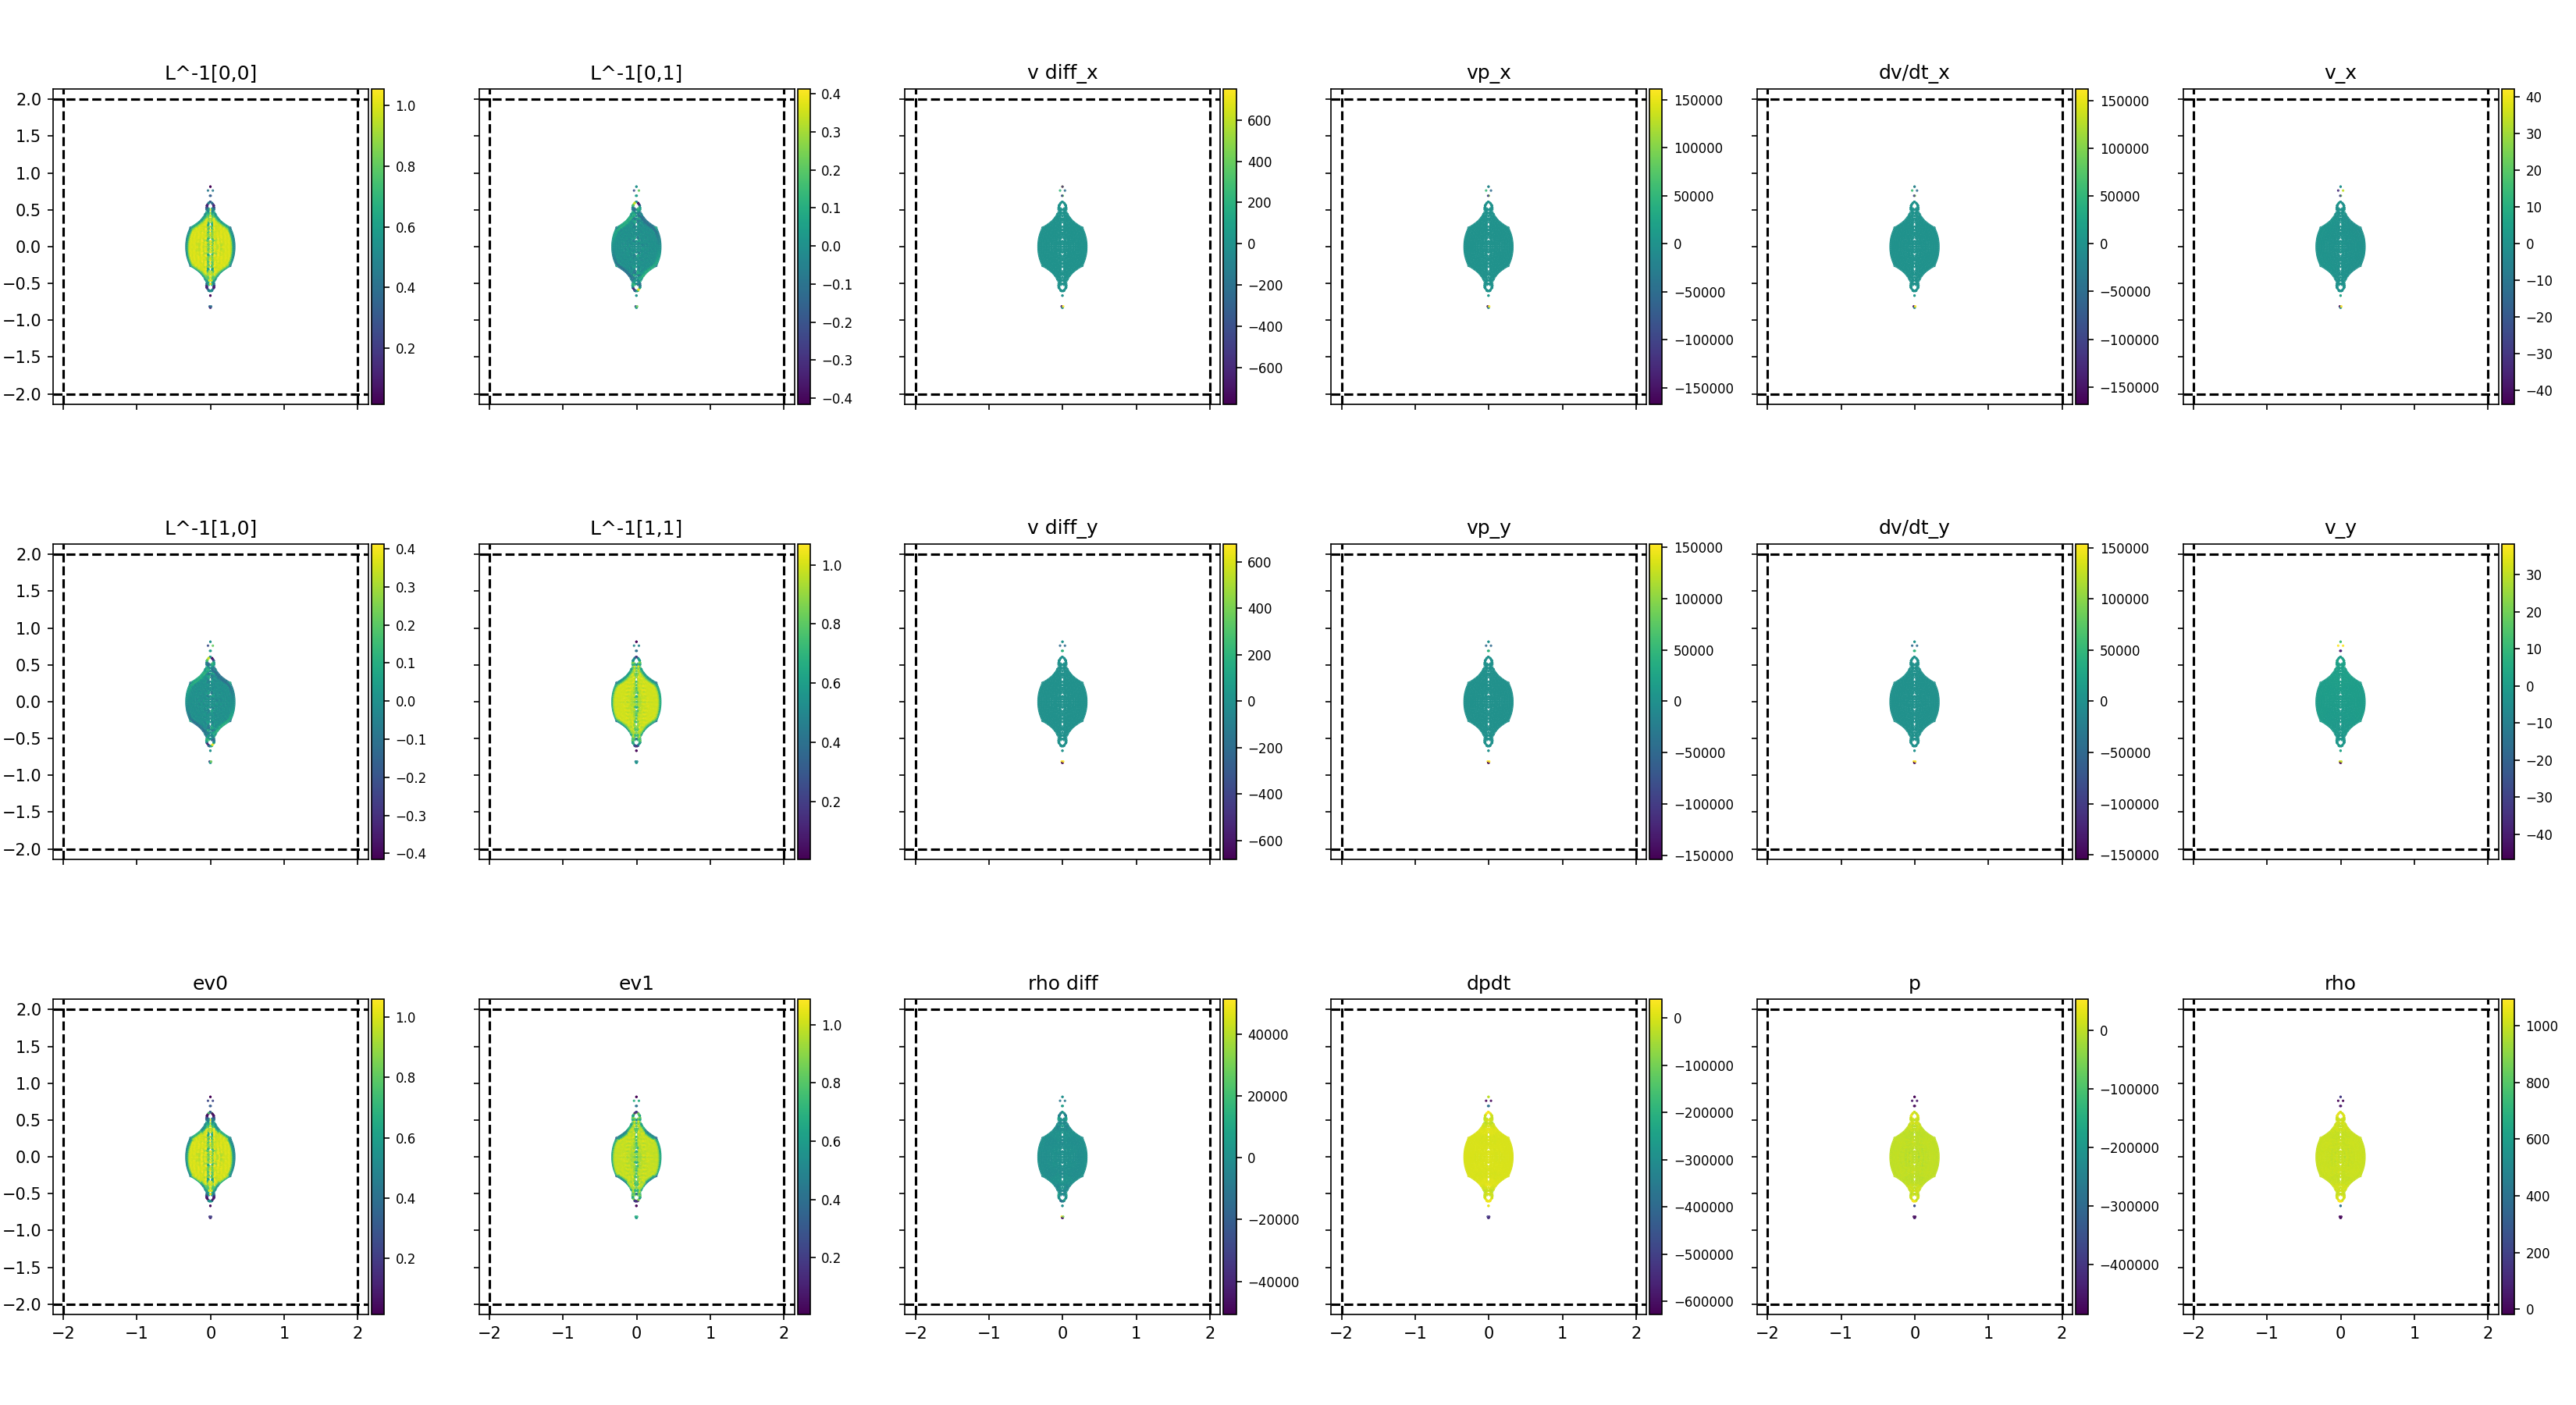

plots [list] = [(<matplotlib.collections.PathCollection object at 0x7f67125781c0>, <matplotlib.colorbar.Colorbar object at 0x7f67305294f0>), (<matplotlib.collections.PathCollection object at 0x7f67326c95e0>, <matplotlib.colorbar.Colorbar object at 0x7f67300eddf0>), (<matplotlib.collections.PathCollection object at 0x7f673e9a3550>, <matplotlib.colorbar.Colorbar object at 0x7f67300fc970>), (<matplotlib.collections.PathCollection object at 0x7f6712e560d0>, <matplotlib.colorbar.Colorbar object at 0x7f6734f202e0>), (<matplotlib.collections.PathCollection object at 0x7f6712fd2130>, <matplotlib.colorbar.Colorbar object at 0x7f6735335160>), (<matplotlib.collections.PathCollection object at 0x7f6745e64b80>, <matplotlib.colorbar.Colorbar object at 0x7f673eb18100>), (<matplotlib.collections.PathCollection object at 0x7f67328142e0>, <matplotlib.colorbar.Colorbar object at 0x7f6737b56310>), (<matplotlib.collections.PathCollection object at 0x7f6712f636a0>, <matplotlib.colorbar.Colorbar object at 0x

In [212]:
deltaModule.plotState(sphSimulation.simulationState, sphSimulation)

In [ ]:
@torch.jit.script
def computeNormalizationMatrix(i, j, r, V, distances, radialDistances, support, numParticles : int, eps : float):
    gradW = kernelGradient(radialDistances, distances, support)

    r_ba = - distances # r[j] - r[i]
    fac = V[j]

    term = torch.einsum('nu,nv -> nuv', r_ba, gradW)
    term[:,0,0] = term[:,0,0] * fac
    term[:,0,1] = term[:,0,1] * fac
    term[:,1,0] = term[:,1,0] * fac
    term[:,1,1] = term[:,1,1] * fac

    fluidNormalizationMatrix = scatter_sum(term, i, dim=0, dim_size=numParticles)
    
    
    fluidL, eigVals = pinv2x2(fluidNormalizationMatrix)

    return fluidNormalizationMatrix, fluidL, eigVals
@torch.jit.script 
def computeRenormalizedDensityGradient(i, j, r, V, distances, radialDistances, support, numParticles : int, eps : float, L, rho):
    gradW = kernelGradient(radialDistances, distances, support)
    
    rho_ba = rho[j] - rho[i] 
    grad = torch.matmul(L[i], gradW.unsqueeze(2))[:,:,0]

    gradMagnitude = torch.linalg.norm(grad, dim=1)
    kernelMagnitude = torch.linalg.norm(gradW, dim=1)        
    change =  torch.abs(gradMagnitude - kernelMagnitude) / (kernelMagnitude + eps)
    grad[change > 0.1,:] = gradW[change > 0.1, :]

    renormalizedGrad = grad
    renormalizedDensityGradient = scatter_sum((rho_ba * V[i] * 2)[:,None] * grad, i, dim = 0, dim_size=numParticles)
    
    return renormalizedGrad, renormalizedDensityGradient

@torch.jit.script
def computeDensityDiffusion(i, j, r, V, distances, radialDistances, support, numParticles : int, eps : float, gradRho, rho, delta : float, c0 : float):
    gradW = kernelGradient(radialDistances, distances, support)
    rji = - distances #r[j] - r[i]
    rji2 = torch.linalg.norm(rji, dim=1)**2 + eps

    psi_ij = (2 * (rho[j] - rho[i]) / rji2)[:,None] * rji - (gradRho[i] + gradRho[j])
    prod = torch.einsum('nu,nu -> n', psi_ij, gradW) 
    return support * delta * c0 * scatter_sum(prod * V[j], i, dim=0, dim_size = numParticles)

@torch.jit.script
def computeDivergenceTerm(i, j, r, V, distances, radialDistances, support, numParticles : int, eps : float, rho, u):
    gradW = kernelGradient(radialDistances, distances, support)

    uji = u[j] - u[i]
    prod = torch.einsum('nu,nu -> n', uji, gradW) 

    return - rho * scatter_sum(prod * V[j], i, dim=0, dim_size = numParticles)
@torch.jit.script
def computeVelocityDiffusion(i, j, r, V, distances, radialDistances, support, numParticles : int, eps : float, rho, u, alpha : float, c0 : float, restDensity : float):
    gradW = kernelGradient(radialDistances, distances, support)

    uji = u[j] - u[i]
    rji = -distances#r[j] - r[i]
    rji2 = torch.linalg.norm(rji, dim=1)**2 + eps

    pi_ij = torch.einsum('nu, nu -> n', uji, rji) / rji2
    term = 8 * (pi_ij * V[j])[:,None] * gradW

    return (support * alpha * c0 * restDensity / rho)[:,None] * scatter_sum(term, i, dim=0, dim_size = numParticles)
@torch.jit.script
def computePressureAccel(i, j, r, V, distances, radialDistances, support, numParticles : int, eps : float, rho, p):
    gradW = kernelGradient(radialDistances, distances, support)

    pij = p[i] + p[j]        
    term = (pij * V[j])[:,None] * gradW

    return - 1 / rho[:,None] * scatter_sum(term, i, dim=0, dim_size = numParticles)
    
    
class deltaSPHModule(Module):
    def getParameters(self):
        return [
            Parameter('deltaSPH', 'alpha', 'float', 0.1, required = False, export = True, hint = ''),
            Parameter('deltaSPH', 'delta', 'float', 0.1, required = False, export = True, hint = ''),
            Parameter('deltaSPH', 'c0', 'float', 0.1, required = False, export = True, hint = '')
        ]
        
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
    
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']    
        self.backgroundPressure = simulationConfig['fluid']['backgroundPressure']
        self.restDensity = simulationConfig['fluid']['restDensity']
        
        self.boundaryScheme = simulationConfig['simulation']['boundaryScheme']
        self.boundaryCounter = len(simulationConfig['solidBC']) if 'solidBC' in simulationConfig else 0

        self.pressureScheme = simulationConfig['simulation']['pressureTerm'] 
        self.computeBodyForces = simulationConfig['simulation']['bodyForces'] 
        
        self.dtype = simulationConfig['compute']['precision']
        self.device = simulationConfig['compute']['device'] 
        
#         self.alpha = simulationConfig['deltaSPH']['alpha']
#         self.delta = simulationConfig['deltaSPH']['delta']  
        self.alpha = 0.1
        self.delta = 0.1
#         self.threshold = 1e-12
        self.c0 = 24.261079942986875
        self.eps = self.support **2 * 0.1
        
    def computeNormalizationMatrices(self, simulationState, simulation):
        with record_function('deltaSPH - compute normalization matrices'):
            self.fluidVolume = simulationState['fluidArea'] * self.restDensity / simulationState['fluidDensity']
            self.fluidNormalizationMatrix, self.fluidL, self.eigVals = computeNormalizationMatrix(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
                                                                                                  simulationState['fluidPosition'], self.fluidVolume,\
                                                                                                  simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
                                                                                                  self.support, simulationState['fluidDensity'].shape[0], self.eps)            
    def computeRenormalizedDensityGradient(self, simulationState, simulation):
        with record_function('deltaSPH - compute renormalized density gradient'):
            self.renormalizedGrad, self.renormalizedDensityGradient = computeRenormalizedDensityGradient(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
                                                                                                  simulationState['fluidPosition'], self.fluidVolume,\
                                                                                                  simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
                                                                                                  self.support, simulationState['fluidDensity'].shape[0], self.eps,\
                                                                                                  self.fluidL, simulationState['fluidDensity'])      
    def computeDensityDiffusion(self, simulationState, simulation):
        with record_function('deltaSPH - compute density diffusion'):
            self.densityDiffusion = computeDensityDiffusion(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
                                                                                                  simulationState['fluidPosition'], self.fluidVolume,\
                                                                                                  simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
                                                                                                  self.support, simulationState['fluidDensity'].shape[0], self.eps,\
                                                                                                  self.renormalizedDensityGradient, simulationState['fluidDensity'],\
                                                                                                  self.delta, self.c0)
    def computeDpDt(self, simulationState, simulation):
        with record_function('deltaSPH - compute drho/dt'):
            self.divergenceTerm = computeDivergenceTerm(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
                                                                                                  simulationState['fluidPosition'], self.fluidVolume,\
                                                                                                  simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
                                                                                                  self.support, simulationState['fluidDensity'].shape[0], self.eps,\
                                                                                                  simulationState['fluidDensity'], simulationState['fluidVelocity'])
            
            self.dpdt = self.divergenceTerm + self.densityDiffusion

    def computePressure(self, simulationState, simulation):
        with record_function('deltaSPH - compute pressure'):
            self.pressure = self.c0**2 * (simulationState['fluidDensity']- self.restDensity)
        
    def computeVelocityDiffusion(self, simulationState, simulation):
        with record_function('deltaSPH - compute velocity diffusion'):
            self.velocityDiffusion = computeVelocityDiffusion(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
                                                                                                  simulationState['fluidPosition'], self.fluidVolume,\
                                                                                                  simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
                                                                                                  self.support, simulationState['fluidDensity'].shape[0], self.eps,\
                                                                                                  simulationState['fluidDensity'], simulationState['fluidVelocity'],
                                                                                                  self.alpha, self.c0, self.restDensity)
    def computePressureAcceleration(self, simulationState, simulation):
        with record_function('deltaSPH - compute pressure acceleration'):
            self.pressureAccel = computePressureAccel(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
                                                                                                  simulationState['fluidPosition'], self.fluidVolume,\
                                                                                                  simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
                                                                                                  self.support, simulationState['fluidDensity'].shape[0], self.eps,\
                                                                                                  simulationState['fluidDensity'], self.pressure)
        
    def computeTerms(self, simulationState, simulation):
        with record_function('deltaSPH - compute terms'):
            self.computeNormalizationMatrices(simulationState, sphSimulation)
            self.computeRenormalizedDensityGradient(simulationState, sphSimulation)
            self.computeDensityDiffusion(simulationState, sphSimulation)
            self.computeDpDt(simulationState, sphSimulation)
            self.computePressure(simulationState, sphSimulation)
            self.computeVelocityDiffusion(simulationState, sphSimulation)
            self.computePressureAcceleration(simulationState, sphSimulation)
        
    def integrate(self, simulationState, simulation):
        with record_function('deltaSPH - integration'):
            simulationState['fluidAcceleration'] += self.pressureAccel + self.velocityDiffusion
            simulationState['fluidVelocity'] += simulationState['dt'] * simulationState['fluidAcceleration']
            simulationState['fluidPosition'] += simulationState['dt'] * simulationState['fluidVelocity']
            simulationState['fluidDensity'] += simulationState['dt'] * self.dpdt
        
    def plotState(self, simulationState, simulation):
        fig, axis = plt.subplots(3,6, figsize=(22, 12), squeeze = False, sharex = True, sharey = True)
        for axx in axis:
            for ax in axx:
                ax.axis('equal')
                ax.set_xlim(sphSimulation.config['domain']['virtualMin'][0], sphSimulation.config['domain']['virtualMax'][0])
                ax.set_ylim(sphSimulation.config['domain']['virtualMin'][1], sphSimulation.config['domain']['virtualMax'][1])
                ax.axvline(sphSimulation.config['domain']['min'][0], ls= '--', c = 'black')
                ax.axvline(sphSimulation.config['domain']['max'][0], ls= '--', c = 'black')
                ax.axhline(sphSimulation.config['domain']['min'][1], ls= '--', c = 'black')
                ax.axhline(sphSimulation.config['domain']['max'][1], ls= '--', c = 'black')

#         positions = simulationState['fluidPosition']
#         M = deltaModule.dpdt

        # bPositions = simulation.boundaryModule.boundaryPositions
        # bM = simulation.boundaryModule.boundaryL
        # bPositions = simulation.boundaryModule.ghostParticlePosition
        # bM = boundaryNormalizationMatrix

        # positions = torch.vstack((positions, bPositions)).detach().cpu().numpy()
        # M = torch.vstack((M, bM)).detach().cpu().numpy()

        # positions = bPositions.detach().cpu().numpy()
        # M = bM.detach().cpu().numpy()

        def scatterPlot(axis, positions, data,title = None):
            if title:
                axis.set_title(title)
            sc = axis.scatter(positions[:,0], positions[:,1], c = data, s = 0.25)
            ax1_divider = make_axes_locatable(axis)
            cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
            cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
            cbar.ax.tick_params(labelsize=8) 
            return sc, cbar

        plots = []

        plots.append(scatterPlot(axis[0,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidNormalizationMatrix[:,0,0].detach().cpu().numpy(), 'L^-1[0,0]'))
        plots.append(scatterPlot(axis[0,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidNormalizationMatrix[:,0,1].detach().cpu().numpy(), 'L^-1[0,1]'))
        plots.append(scatterPlot(axis[1,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidNormalizationMatrix[:,1,0].detach().cpu().numpy(), 'L^-1[1,0]'))
        plots.append(scatterPlot(axis[1,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidNormalizationMatrix[:,1,1].detach().cpu().numpy(), 'L^-1[1,1]'))
        
#         plots.append(scatterPlot(axis[0,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidL[:,0,0].detach().cpu().numpy(), 'L^-1[0,0]'))
#         plots.append(scatterPlot(axis[0,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidL[:,0,1].detach().cpu().numpy(), 'L^-1[0,1]'))
#         plots.append(scatterPlot(axis[1,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidL[:,1,0].detach().cpu().numpy(), 'L^-1[1,0]'))
#         plots.append(scatterPlot(axis[1,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidL[:,1,1].detach().cpu().numpy(), 'L^-1[1,1]'))

#         plots.append(scatterPlot(axis[2,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.renormalizedDensityGradient[:,0].detach().cpu().numpy(), '<Vrho>_x'))
#         plots.append(scatterPlot(axis[2,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.renormalizedDensityGradient[:,1].detach().cpu().numpy(), '<Vrho>_y'))

        plots.append(scatterPlot(axis[2,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.eigVals[:,0].detach().cpu().numpy(), 'ev0'))
        plots.append(scatterPlot(axis[2,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.eigVals[:,1].detach().cpu().numpy(), 'ev1'))

        plots.append(scatterPlot(axis[2,2], simulationState['fluidPosition'].detach().cpu().numpy(), self.densityDiffusion.detach().cpu().numpy(), 'rho diff'))
        plots.append(scatterPlot(axis[2,3], simulationState['fluidPosition'].detach().cpu().numpy(), self.dpdt.detach().cpu().numpy(), 'dpdt'))
        plots.append(scatterPlot(axis[2,4], simulationState['fluidPosition'].detach().cpu().numpy(), self.pressure.detach().cpu().numpy(), 'p'))

        plots.append(scatterPlot(axis[0,2], simulationState['fluidPosition'].detach().cpu().numpy(), self.velocityDiffusion[:,0].detach().cpu().numpy(), 'v diff_x'))
        plots.append(scatterPlot(axis[1,2], simulationState['fluidPosition'].detach().cpu().numpy(), self.velocityDiffusion[:,1].detach().cpu().numpy(), 'v diff_y'))

        plots.append(scatterPlot(axis[0,3], simulationState['fluidPosition'].detach().cpu().numpy(), self.pressureAccel[:,0].detach().cpu().numpy(), 'vp_x'))
        plots.append(scatterPlot(axis[1,3], simulationState['fluidPosition'].detach().cpu().numpy(), self.pressureAccel[:,1].detach().cpu().numpy(), 'vp_y'))
        
        plots.append(scatterPlot(axis[0,4], simulationState['fluidPosition'].detach().cpu().numpy(), simulationState['fluidAcceleration'][:,0].detach().cpu().numpy(), 'dv/dt_x'))
        plots.append(scatterPlot(axis[1,4], simulationState['fluidPosition'].detach().cpu().numpy(), simulationState['fluidAcceleration'][:,1].detach().cpu().numpy(), 'dv/dt_y'))

        plots.append(scatterPlot(axis[0,5], simulationState['fluidPosition'].detach().cpu().numpy(), simulationState['fluidVelocity'][:,0].detach().cpu().numpy(), 'v_x'))
        plots.append(scatterPlot(axis[1,5], simulationState['fluidPosition'].detach().cpu().numpy(), simulationState['fluidVelocity'][:,1].detach().cpu().numpy(), 'v_y'))
        
        plots.append(scatterPlot(axis[2,5], simulationState['fluidPosition'].detach().cpu().numpy(), simulationState['fluidDensity'].detach().cpu().numpy(), 'rho'))

        fig.tight_layout()

        self.plots = plots
        self.fig = fig
#         debugPrint(plots)
        
    def updatePlots(self, simulationState, simulation):
        positions = simulationState['fluidPosition'].detach().cpu().numpy()
        for i, (sc, cbar) in enumerate(self.plots):
            data = []
#             if i ==  0: data = self.fluidL[:,0,0].detach().cpu().numpy()
#             if i ==  1: data = self.fluidL[:,0,1].detach().cpu().numpy()
#             if i ==  2: data = self.fluidL[:,1,0].detach().cpu().numpy()
#             if i ==  3: data = self.fluidL[:,1,1].detach().cpu().numpy()
            if i ==  0: data = self.fluidNormalizationMatrix[:,0,0].detach().cpu().numpy()
            if i ==  1: data = self.fluidNormalizationMatrix[:,0,1].detach().cpu().numpy()
            if i ==  2: data = self.fluidNormalizationMatrix[:,1,0].detach().cpu().numpy()
            if i ==  3: data = self.fluidNormalizationMatrix[:,1,1].detach().cpu().numpy()
#             if i ==  4: data = self.renormalizedDensityGradient[:,0].detach().cpu().numpy()
#             if i ==  5: data = self.renormalizedDensityGradient[:,1].detach().cpu().numpy()
            if i ==  4: data = self.eigVals[:,0].detach().cpu().numpy()
            if i ==  5: data = self.eigVals[:,1].detach().cpu().numpy()
            if i ==  6: data = self.densityDiffusion.detach().cpu().numpy()
            if i ==  7: data = self.dpdt.detach().cpu().numpy()                
            if i ==  8: data = self.pressure.detach().cpu().numpy()
            if i ==  9: data = self.velocityDiffusion[:,0].detach().cpu().numpy()
            if i == 10: data = self.velocityDiffusion[:,1].detach().cpu().numpy()
            if i == 11: data = self.pressureAccel[:,0].detach().cpu().numpy()
            if i == 12: data = self.pressureAccel[:,1].detach().cpu().numpy()
            if i == 13: data = simulationState['fluidAcceleration'][:,0].detach().cpu().numpy()
            if i == 14: data = simulationState['fluidAcceleration'][:,1].detach().cpu().numpy()
            if i == 15: data = simulationState['fluidVelocity'][:,0].detach().cpu().numpy()
            if i == 16: data = simulationState['fluidVelocity'][:,1].detach().cpu().numpy()
            if i == 17: data = simulationState['fluidDensity'].detach().cpu().numpy()
            
            sc.set_offsets(positions)
            sc.set_array(data)
            cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()


        

<IPython.core.display.Javascript object>


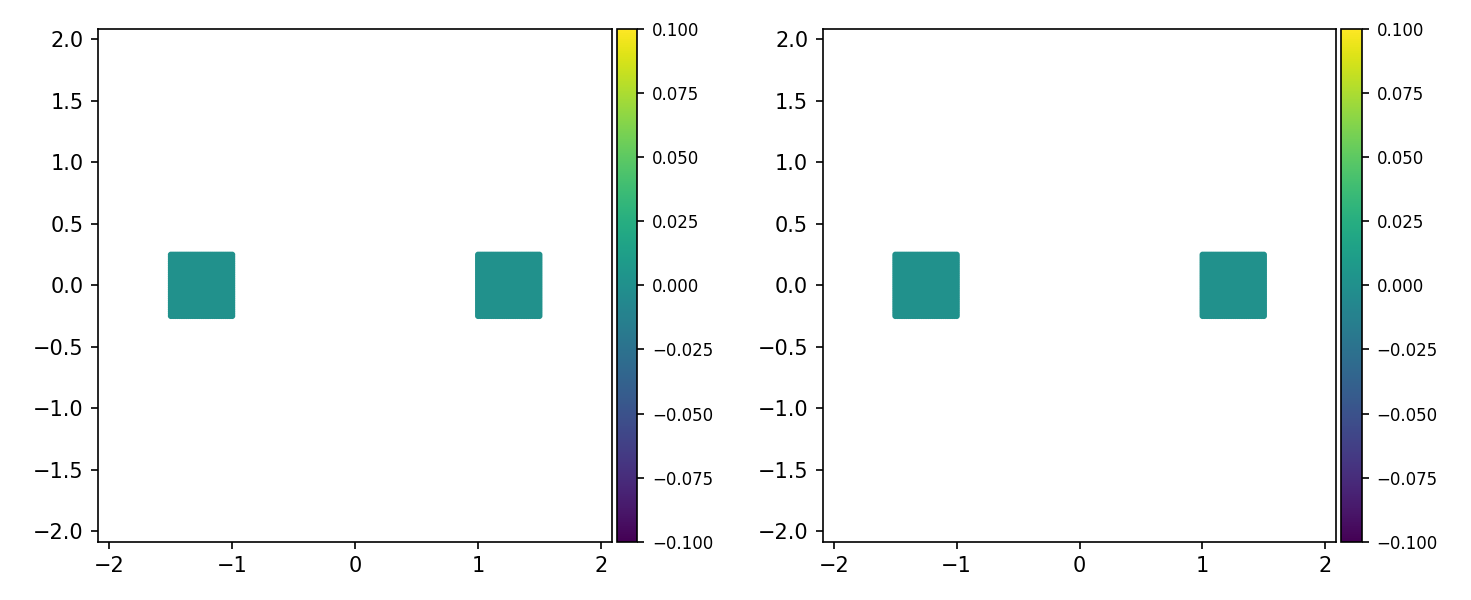

In [33]:
fig, axis = plt.subplots(1,2, figsize=(9 *  1.09, 4), squeeze = False)
for axx in axis:
    for ax in axx:
        ax.axis('equal')
        ax.set_xlim(sphSimulation.config['domain']['virtualMin'][0], sphSimulation.config['domain']['virtualMax'][0])
        ax.set_ylim(sphSimulation.config['domain']['virtualMin'][1], sphSimulation.config['domain']['virtualMax'][1])
#         ax.axvline(sphSimulation.config['domain']['min'][0], ls= '--', c = 'black')
#         ax.axvline(sphSimulation.config['domain']['max'][0], ls= '--', c = 'black')
#         ax.axhline(sphSimulation.config['domain']['min'][1], ls= '--', c = 'black')
#         ax.axhline(sphSimulation.config['domain']['max'][1], ls= '--', c = 'black')

positions = simulationState['fluidPosition']
M = deltaModule.renormalizedDensityGradient

# bPositions = simulation.boundaryModule.boundaryPositions
# bM = simulation.boundaryModule.boundaryL
# bPositions = simulation.boundaryModule.ghostParticlePosition
# bM = boundaryNormalizationMatrix

# positions = torch.vstack((positions, bPositions)).detach().cpu().numpy()
# M = torch.vstack((M, bM)).detach().cpu().numpy()

# positions = bPositions.detach().cpu().numpy()
# M = bM.detach().cpu().numpy()

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = M[:,0], s = 4)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 
sc = axis[0,1].scatter(positions[:,0], positions[:,1], c = M[:,1], s = 4)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.tight_layout()

In [ ]:
fig, axis = plt.subplots(2,2, figsize=(9 *  1.09, 9), squeeze = False)
for axx in axis:
    for ax in axx:
        ax.axis('equal')
        ax.set_xlim(sphSimulation.config['domain']['virtualMin'][0], sphSimulation.config['domain']['virtualMax'][0])
        ax.set_ylim(sphSimulation.config['domain']['virtualMin'][1], sphSimulation.config['domain']['virtualMax'][1])
#         ax.axvline(sphSimulation.config['domain']['min'][0], ls= '--', c = 'black')
#         ax.axvline(sphSimulation.config['domain']['max'][0], ls= '--', c = 'black')
#         ax.axhline(sphSimulation.config['domain']['min'][1], ls= '--', c = 'black')
#         ax.axhline(sphSimulation.config['domain']['max'][1], ls= '--', c = 'black')

positions = simulationState['fluidPosition']
M = deltaModule.fluidL

bPositions = simulation.boundaryModule.boundaryPositions
bM = simulation.boundaryModule.boundaryL
# bPositions = simulation.boundaryModule.ghostParticlePosition
# bM = boundaryNormalizationMatrix

positions = torch.vstack((positions, bPositions)).detach().cpu().numpy()
M = torch.vstack((M, bM)).detach().cpu().numpy()

# positions = bPositions.detach().cpu().numpy()
# M = bM.detach().cpu().numpy()

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = M[:,0,0], s = 4)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 
sc = axis[0,1].scatter(positions[:,0], positions[:,1], c = M[:,0,1], s = 4)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 
sc = axis[1,0].scatter(positions[:,0], positions[:,1], c = M[:,1,0], s = 4)
ax1_divider = make_axes_locatable(axis[1,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 
sc = axis[1,1].scatter(positions[:,0], positions[:,1], c = M[:,1,1], s = 4)
ax1_divider = make_axes_locatable(axis[1,1])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.tight_layout()

In [ ]:
for i in tqdm(range(1024)):
    sphSimulation.timestep()

    
#     positions2 = state['akinciBoundary']['positions'].detach().cpu().numpy()
    # data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
#     data2 = state['akinciBoundary']['boundaryDensity'].detach().cpu().numpy()


    positions = state['fluidPosition'].detach().cpu().numpy()
    # data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
#     data2 = state['akinciBoundary']['boundaryDensity'].detach().cpu().numpy()
    data = state['fluidDensity'].detach().cpu().numpy()
#     data2 = state['akinciBoundary']['boundaryPressure'].detach().cpu().numpy()
#     data = state['fluidPressure'].detach().cpu().numpy()


#     positions = np.vstack((positions, positions2))
#     data = np.hstack((data, data2))

    positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
    data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy()

    positions = np.vstack((positions, positions2))
    data = np.hstack((data, data2))


    sc.set_offsets(positions)
    sc.set_array(data)
    cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    fig.canvas.draw()
    fig.canvas.flush_events()
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
    if 'densityErrors' in state and not 'divergenceErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
    if 'divergenceErrors' in state and not 'densityErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
    if 'densityErrors' in state and 'divergenceErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))


#     if torch.any(torch.isnan(state['boundaryDensity'])) or torch.any(torch.isnan(state['boundaryGradient'])):
#         raise Exception('Simulation borked')

In [ ]:


with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    for i in range(1):
        with record_function("full Timestep"): 
            sphSimulation.timestep()
        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")